<a href="https://colab.research.google.com/github/renardelyon/Classification/blob/main/Video_Classification_with_Pre_Trained_Models_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Copyright 2020 Google LLC.

In [1]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Video Classification with Pre-Trained Models Project

In this project we will import a pre-existing model that recognizes objects and use the model to identify those objects in a video. We'll edit the video to draw boxes around the identified object, and then we'll reassemble the video so the boxes are shown around objects in the video.

# Exercises

## Exercise 1: Coding

You will process a video frame by frame, identify objects in each frame, and draw a bounding box with a label around each car in the video.
 
Use the [SSD MobileNet V1 Coco](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf1_detection_zoo.md) (*ssd_mobilenet_v1_coco*) model. The video you'll process can be found [on Pixabay](https://pixabay.com/videos/cars-motorway-speed-motion-traffic-1900/). The 640x360 version of the video is smallest and easiest to handle, though any size should work since you must scale down the images for processing.
 
Your program should:
 
* Read in a video file (use the one in this colab if you want)
* Load the TensorFlow model linked above
* Loop over each frame of the video
* Scale the frame down to a size the model expects
* Feed the frame to the model
* Loop over detections made by the model
* If the detection score is above some threshold, draw a bounding box onto the frame and put a label in or near the box
* Write the frame back to a new video
 
Some tips:
 
* Processing an entire video is slow, so consider truncating the video or skipping over frames during development. Skipping frames will make the video choppy. But you'll be able to see a wider variety of images than you would with a truncated video with all of the original frames in the clip.
* The model expects a 300x300 image. You'll likely have to scale your frames to fit the model. When you get a bounding box, that box is relative to the scaled image. You'll need to scale the bounding box out to the original image size.
* Don't start by trying to process the video. Instead, capture one frame and work with it until you are happy with your object detection, bounding boxes, and labels. Once you get those done, use the same logic on the other frames of the video.
* The [Coco labels file](https://github.com/nightrome/cocostuff/blob/master/labels.txt) can be used to identify classified objects.
 

### **Student Solution**

In [2]:
#import pretrained model
import urllib.request
import os

base_url = 'http://download.tensorflow.org/models/object_detection/'
file_name = 'ssd_mobilenet_v1_coco_2018_01_28.tar.gz'

url = base_url + file_name

urllib.request.urlretrieve(url, file_name)

os.listdir()

['.config',
 'ssd_mobilenet_v1_coco_2018_01_28.tar.gz',
 '.ipynb_checkpoints',
 'coco.txt',
 'Cars - 1900.mp4',
 'sample_data']

In [3]:
#extract model data
import tarfile
import shutil

dir_name = file_name[0:-len('.tar.gz')]

if os.path.exists(dir_name):
  shutil.rmtree(dir_name) 

tarfile.open(file_name, 'r:gz').extractall('./')

os.listdir(dir_name)

['model.ckpt.data-00000-of-00001',
 'pipeline.config',
 'checkpoint',
 'model.ckpt.index',
 'frozen_inference_graph.pb',
 'saved_model',
 'model.ckpt.meta']

In [4]:
#load frozen graph
import tensorflow as tf

frozen_graph = os.path.join(dir_name, 'frozen_inference_graph.pb')

with tf.io.gfile.GFile(frozen_graph, "rb") as f:
  graph_def = tf.compat.v1.GraphDef()
  loaded = graph_def.ParseFromString(f.read())

In [5]:
len(graph_def.node)

5960

In [6]:
#load the model
def wrap_graph(graph_def, inputs, outputs, print_graph=False):
  wrapped = tf.compat.v1.wrap_function(
    lambda: tf.compat.v1.import_graph_def(graph_def, name=""), [])

  return wrapped.prune(
    tf.nest.map_structure(wrapped.graph.as_graph_element, inputs),
    tf.nest.map_structure(wrapped.graph.as_graph_element, outputs))

outputs = (
  'num_detections:0',
  'detection_classes:0',
  'detection_scores:0',
  'detection_boxes:0',
)

model = wrap_graph(graph_def=graph_def,
                   inputs=["image_tensor:0"],
                   outputs=outputs)

In [7]:
#Read video file
import cv2 as cv
import re
import os

names=[]
for name in os.listdir():
  nama = re.search('([\w\d .-]*.mp4)',name)
  if nama is not None:
    names.append(nama.group(1))
cars_video = cv.VideoCapture(names[0])

In [8]:
#display information about the video

height = int(cars_video.get(cv.CAP_PROP_FRAME_HEIGHT))
width = int(cars_video.get(cv.CAP_PROP_FRAME_WIDTH))
fps = cars_video.get(cv.CAP_PROP_FPS)
total_frames = int(cars_video.get(cv.CAP_PROP_FRAME_COUNT))

print(f'height: {height}')
print(f'width: {width}')
print(f'frames per second: {fps}')
print(f'total frames: {total_frames}')
print(f'video length (seconds): {total_frames / fps}')

height: 360
width: 640
frames per second: 25.0
total frames: 1501
video length (seconds): 60.04


In [9]:
#open coco label file and assign it to dictionary
coco_dict = {}
with open('coco.txt','r') as lines:
  for line in lines:
      key, value = line.split(':')

      coco_dict[int(key)] = value.strip()

print(coco_dict)

{0: 'unlabeled', 1: 'person', 2: 'bicycle', 3: 'car', 4: 'motorcycle', 5: 'airplane', 6: 'bus', 7: 'train', 8: 'truck', 9: 'boat', 10: 'traffic light', 11: 'fire hydrant', 12: 'street sign', 13: 'stop sign', 14: 'parking meter', 15: 'bench', 16: 'bird', 17: 'cat', 18: 'dog', 19: 'horse', 20: 'sheep', 21: 'cow', 22: 'elephant', 23: 'bear', 24: 'zebra', 25: 'giraffe', 26: 'hat', 27: 'backpack', 28: 'umbrella', 29: 'shoe', 30: 'eye glasses', 31: 'handbag', 32: 'tie', 33: 'suitcase', 34: 'frisbee', 35: 'skis', 36: 'snowboard', 37: 'sports ball', 38: 'kite', 39: 'baseball bat', 40: 'baseball glove', 41: 'skateboard', 42: 'surfboard', 43: 'tennis racket', 44: 'bottle', 45: 'plate', 46: 'wine glass', 47: 'cup', 48: 'fork', 49: 'knife', 50: 'spoon', 51: 'bowl', 52: 'banana', 53: 'apple', 54: 'sandwich', 55: 'orange', 56: 'broccoli', 57: 'carrot', 58: 'hot dog', 59: 'pizza', 60: 'donut', 61: 'cake', 62: 'chair', 63: 'couch', 64: 'potted plant', 65: 'bed', 66: 'mirror', 67: 'dining table', 68: '

###Object Detection Trial with One Frame from the video

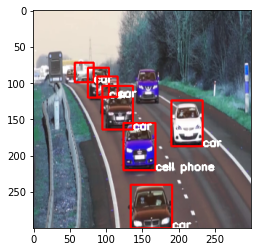

In [39]:
#display one frame from the video
import matplotlib.pyplot as plt

cars_video = cv.VideoCapture(names[0])
cars_video.set(cv.CAP_PROP_POS_FRAMES, 1)
ret, frame = cars_video.read()
if not ret:
  raise Exception(f'Problem reading frame from video')

cars_video.release()

processed_frame = model_prediction(frame)
plt.imshow(processed_frame)
plt.show()

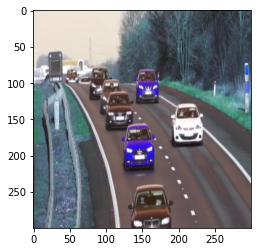

In [11]:
#resize the frame
frame_scaled = cv.resize(frame, (300, 300))

plt.imshow(frame_scaled)
plt.show()

In [12]:
#expand frame dimension from (N,N,N) to (1,N,N,N)
input_image = [frame_scaled]

In [13]:
#convert image 
tensor = tf.convert_to_tensor(input_image, dtype=tf.uint8)

detections = model(tensor)

In [14]:

detections_box = detections[3].numpy().squeeze()
detections_class = detections[1].numpy().squeeze()


box = detections_box[detections_class != (0 or 1)] 
dt_class = detections_class[detections_class != (0 or 1)].astype('int64')

#multiply box in x coordinates by 426 and y coord with 640
box[:,(0,2)] *= 300
box[:,(1,3)] *= 300

print(dt_class)


[77  3  3  3  3  3  3]


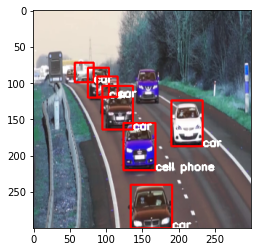

In [15]:
import numpy as np

frame_copy = np.copy(frame_scaled)

r = 255
g = 255
b = 255
scale = .5
thickness = 2

for i in range(len(box)): 
    cv.rectangle(frame_copy,(box[i,1],box[i,0]),
                 (box[i,3],box[i,2]),
                 [255,0,0],2)
    
    left = 150
    top = 50

    cv.putText(frame_copy, coco_dict[dt_class[i]], 
               (box[i,3],box[i,2]), 
               cv.FONT_HERSHEY_SIMPLEX, scale,
           [r, g, b], thickness)
  
_ = plt.imshow(frame_copy)

###Object Detection for all frames in the video

In [40]:
def model_prediction(frame):
  #resize the frame
  frame_scaled = cv.resize(frame, (300, 300))
  #expand dim frame_scaled, convert it to tensor, an feed it to the model
  input_image = [frame_scaled]
  tensor = tf.convert_to_tensor(input_image, dtype=tf.uint8)
  detections = model(tensor)

  detections_box = detections[3].numpy().squeeze()
  detections_class = detections[1].numpy().squeeze()


  box = detections_box[detections_class != (0 or 1)] 
  dt_class = detections_class[detections_class != (0 or 1)].astype('int64')

  #multiply box in x coordinates by 426 and y coord with 640
  box[:,(0,2)] *= 300
  box[:,(1,3)] *= 300

  frame_copy = np.copy(frame_scaled)

  r = 255
  g = 255
  b = 255
  scale = .5
  thickness = 2

  for i in range(len(box)): 
      cv.rectangle(frame_copy,(box[i,1],box[i,0]),
                  (box[i,3],box[i,2]),
                  [255,0,0],2)

      cv.putText(frame_copy, coco_dict[dt_class[i]], 
                (box[i,3],box[i,2]), 
                cv.FONT_HERSHEY_SIMPLEX, scale,
                [r, g, b], thickness)
  
  return frame_copy


In [41]:
#Open input video
input_video = cv.VideoCapture(names[0])
total_frames = int(input_video.get(cv.CAP_PROP_FRAME_COUNT))
#Tell openCV which video format to use
fourcc = cv.VideoWriter_fourcc(*'mp4v')
output_video = cv.VideoWriter('cars-sampled.mp4', fourcc, 25, (300, 300))

In [42]:
skip_frame = 5 #Amount of frame that skip
frame_used = total_frames//skip_frame

for current_frame in range(0, frame_used):
  input_video.set(cv.CAP_PROP_POS_FRAMES, skip_frame*current_frame)
  ret, frame = input_video.read()
  if not ret:
    raise Exception(f'Problem reading frame {current_frame} from video')
  processed_frame = model_prediction(frame)
  output_video.write(processed_frame)
   

In [43]:
input_video.release()
output_video.release()

---

## Exercise 2: Ethical Implications

Even the most basic models have the potential to affect segments of the population in different ways. It is important to consider how your model might positively and negatively affect different types of users.

In this section of the project, you will reflect on the positive and negative implications of your model. Frame the context of your model creation using this narrative:

> The city of Seattle is attempting to reduce traffic congestion in its downtown area. As part of this project, they plan to allow each local driver one free trip to downtown Seattle per week. After that, the driver will have to pay a $50 toll for each extra day per week driven. As an early proof of concept for this project, your team is tasked with using machine learning to correctly identify automobiles on the road. The next phase of the project will involve detecting license plate numbers and then cross-referencing that data with RFID chips that should be mounted in all local drivers' cars.

### **Student Solution**

**Positive Impact**

Your model is trying to solve a problem. Think about who will benefit from that problem being solved and write a brief narrative about how the model will help.

> *Hypothetical entities will benefit because...*


**Negative Impact**

Models rarely benefit everyone equally. Think about who might be negatively impacted by the predictions your model is making. This person(s) might not be directly using the model, but they might be impacted indirectly.

> *Hypothetical entities will be negatively impacted because...*

**Bias**

Models can be biased for many reasons. The bias can come from the data used to build the model (e.g., sampling, data collection methods, available sources) and/or from the interpretation of the predictions generated by the model.

Think of at least two ways bias might have been introduced to your model and explain both below.

> *One source of bias in the model could be...*

> *Another source of bias in the model could be...*

**Changing the Dataset to Mitigate Bias**

Having bias in your dataset is one of the primary ways in which bias is introduced to a machine learning model. Look back at the input data you fed to your model. Think about how you might change something about the data to reduce bias in your model.

What change or changes could you make to reduce the bias in your dataset? Consider the data you have, how and where it was collected, and what other sources of data might be used to reduce bias.

Write a summary of changes that could be made to your input data.

> *Since the data has potential bias A we can adjust...*

**Changing the Model to Mitigate Bias**

Is there any way to reduce bias by changing the model itself? This could include modifying algorithmic choices, tweaking hyperparameters, etc.

Write a brief summary of changes you could make to help reduce bias in your model.

> *Since the model has potential bias A, we can adjust...*

**Mitigating Bias Downstream**

Models make predictions. Downstream processes make decisions. What processes and/or rules should be in place for people and systems interpreting and acting on the results of your model to reduce bias? Describe these rules and/or processes below.

> *Since the predictions have potential bias A, we can adjust...*

---